# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Tue Mar 24 00:28:27 2020


In [2]:
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.albumentationstransforms as preprocessing
import src.utils.utils as utils
import src.models.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.customcompose as customcompose
from src.train.lrfinder.lrfinder import LRFinder
import src.train.train_model
%config IPCompleter.greedy=True
%reload_ext autoreload


In [3]:
%autoreload 2  # Autoreload all modules

In [4]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)

In [5]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
      print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
      print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
      print('re-execute this cell.')
    else:
      print('You are using a high-RAM runtime!')

In [6]:
import torch
print(torch.__version__)

1.4.0


In [7]:
# mean,std= utils.Utils.calculatemeanandstddeviation()
# print("mean: " + str(mean))
# print("std: " + str(std))
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

In [8]:
ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
batch_size = 64
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

CUDA Available? True
64


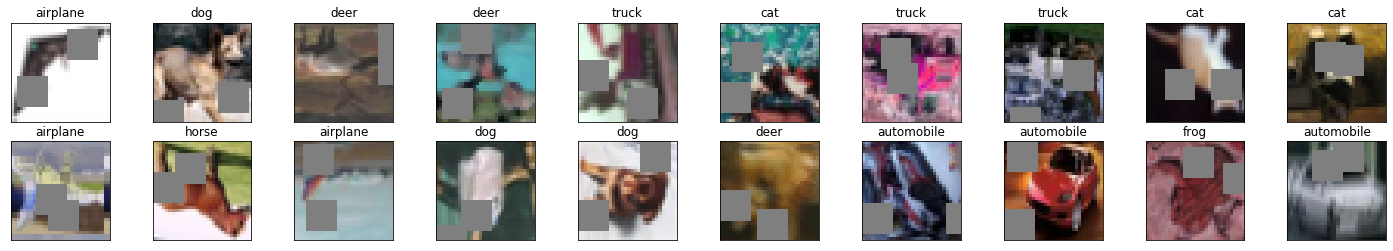

In [10]:
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()

#TODO show transformed images fom dataset
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [11]:
cnn_model, device = utils.Utils.createmodelresnet18()
train_model = train.TrainModel()
train_model.showmodelsummary(cnn_model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [12]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.06, momentum=0.9, weight_decay=0, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



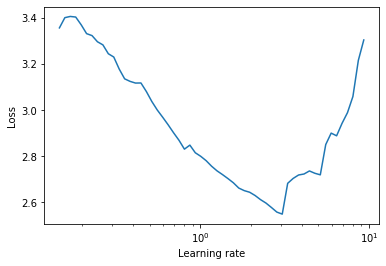

In [13]:
lr_finder = LRFinder(cnn_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()

In [14]:
lr_finder.reset()

In [15]:
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


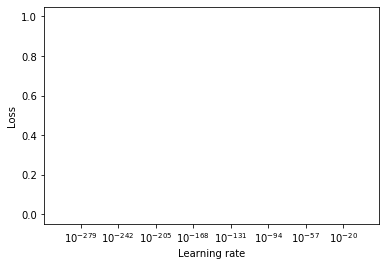

In [16]:
lr_finder.plot(skip_end=0)

In [17]:
lr_finder.reset()

In [18]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.06, momentum=0.9, weight_decay=0, nesterov=True)
scheduler = utils.Utils.createscheduler(optimizer, mode='max', factor=0.9, patience=2,
                                        verbose=True)

In [19]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 150
for epoch in range(1, epochs+1):
    print("EPOCH:", epoch)
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(cnn_model, device, test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch)
    scheduler.step(t_acc_epoch)
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch + 1)  # print LR for different epochs
        lr_data.append(param_groups['lr'])

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.9933308362960815 Batch_id=781 Accuracy=26.94: 100%|██████████| 782/782 [01:08<00:00, 11.40it/s]



Test set: Average loss: 0.0271, Accuracy: 3551/10000 (35.51%)

Validation accuracy increased (0.000000 --> 35.510000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  2
EPOCH: 2


Loss=1.2710535526275635 Batch_id=781 Accuracy=36.22: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]



Test set: Average loss: 0.0233, Accuracy: 4621/10000 (46.21%)

Validation accuracy increased (35.510000 --> 46.210000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  3
EPOCH: 3


Loss=2.522991895675659 Batch_id=781 Accuracy=41.20: 100%|██████████| 782/782 [02:08<00:00,  6.08it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 4161/10000 (41.61%)

Learning rate = 0.06  for epoch:  4
EPOCH: 4


Loss=1.574359655380249 Batch_id=781 Accuracy=45.09: 100%|██████████| 782/782 [02:20<00:00,  5.57it/s] 



Test set: Average loss: 0.0198, Accuracy: 5452/10000 (54.52%)

Validation accuracy increased (46.210000 --> 54.520000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  5
EPOCH: 5


Loss=1.6028902530670166 Batch_id=781 Accuracy=48.43: 100%|██████████| 782/782 [02:26<00:00,  5.34it/s]



Test set: Average loss: 0.0186, Accuracy: 5764/10000 (57.64%)

Validation accuracy increased (54.520000 --> 57.640000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  6
EPOCH: 6


Loss=1.4945266246795654 Batch_id=781 Accuracy=51.38: 100%|██████████| 782/782 [02:30<00:00,  5.21it/s]



Test set: Average loss: 0.0166, Accuracy: 6281/10000 (62.81%)

Validation accuracy increased (57.640000 --> 62.810000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  7
EPOCH: 7


Loss=1.4124013185501099 Batch_id=781 Accuracy=53.70: 100%|██████████| 782/782 [02:29<00:00,  5.24it/s]



Test set: Average loss: 0.0161, Accuracy: 6353/10000 (63.53%)

Validation accuracy increased (62.810000 --> 63.530000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  8
EPOCH: 8


Loss=0.7276716828346252 Batch_id=781 Accuracy=55.84: 100%|██████████| 782/782 [02:29<00:00,  5.22it/s]



Test set: Average loss: 0.0146, Accuracy: 6713/10000 (67.13%)

Validation accuracy increased (63.530000 --> 67.130000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  9
EPOCH: 9


Loss=1.2212332487106323 Batch_id=781 Accuracy=57.68: 100%|██████████| 782/782 [02:31<00:00,  5.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 6520/10000 (65.20%)

Learning rate = 0.06  for epoch:  10
EPOCH: 10


Loss=1.7212498188018799 Batch_id=781 Accuracy=59.64: 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]



Test set: Average loss: 0.0142, Accuracy: 6877/10000 (68.77%)

Validation accuracy increased (67.130000 --> 68.770000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  11
EPOCH: 11


Loss=1.3185256719589233 Batch_id=781 Accuracy=61.23: 100%|██████████| 782/782 [02:37<00:00,  4.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 6830/10000 (68.30%)

Learning rate = 0.06  for epoch:  12
EPOCH: 12


Loss=0.8669145107269287 Batch_id=781 Accuracy=62.84: 100%|██████████| 782/782 [02:33<00:00,  5.08it/s]



Test set: Average loss: 0.0136, Accuracy: 7052/10000 (70.52%)

Validation accuracy increased (68.770000 --> 70.520000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  13
EPOCH: 13


Loss=0.5996714234352112 Batch_id=781 Accuracy=64.16: 100%|██████████| 782/782 [02:33<00:00,  5.09it/s]



Test set: Average loss: 0.0112, Accuracy: 7553/10000 (75.53%)

Validation accuracy increased (70.520000 --> 75.530000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  14
EPOCH: 14


Loss=0.8315032124519348 Batch_id=781 Accuracy=65.87: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 7383/10000 (73.83%)

Learning rate = 0.06  for epoch:  15
EPOCH: 15


Loss=1.2695198059082031 Batch_id=781 Accuracy=66.98: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s]



Test set: Average loss: 0.0105, Accuracy: 7723/10000 (77.23%)

Validation accuracy increased (75.530000 --> 77.230000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  16
EPOCH: 16


Loss=0.5874980688095093 Batch_id=781 Accuracy=68.10: 100%|██████████| 782/782 [02:34<00:00,  5.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 7702/10000 (77.02%)

Learning rate = 0.06  for epoch:  17
EPOCH: 17


Loss=1.1563825607299805 Batch_id=781 Accuracy=68.77: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s]



Test set: Average loss: 0.0106, Accuracy: 7759/10000 (77.59%)

Validation accuracy increased (77.230000 --> 77.590000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  18
EPOCH: 18


Loss=0.44464313983917236 Batch_id=781 Accuracy=70.16: 100%|██████████| 782/782 [02:39<00:00,  4.89it/s]



Test set: Average loss: 0.0094, Accuracy: 7913/10000 (79.13%)

Validation accuracy increased (77.590000 --> 79.130000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  19
EPOCH: 19


Loss=0.670735776424408 Batch_id=781 Accuracy=70.65: 100%|██████████| 782/782 [02:37<00:00,  4.95it/s]  



Test set: Average loss: 0.0093, Accuracy: 7963/10000 (79.63%)

Validation accuracy increased (79.130000 --> 79.630000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  20
EPOCH: 20


Loss=1.065212607383728 Batch_id=781 Accuracy=71.65: 100%|██████████| 782/782 [02:43<00:00,  4.79it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7887/10000 (78.87%)

Learning rate = 0.06  for epoch:  21
EPOCH: 21


Loss=0.5689557790756226 Batch_id=781 Accuracy=72.22: 100%|██████████| 782/782 [02:37<00:00,  4.95it/s] 



Test set: Average loss: 0.0088, Accuracy: 8106/10000 (81.06%)

Validation accuracy increased (79.630000 --> 81.060000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  22
EPOCH: 22


Loss=0.6071500778198242 Batch_id=781 Accuracy=73.31: 100%|██████████| 782/782 [02:42<00:00,  4.80it/s] 



Test set: Average loss: 0.0084, Accuracy: 8195/10000 (81.95%)

Validation accuracy increased (81.060000 --> 81.950000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  23
EPOCH: 23


Loss=0.7798323035240173 Batch_id=781 Accuracy=73.57: 100%|██████████| 782/782 [02:38<00:00,  4.92it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 8055/10000 (80.55%)

Learning rate = 0.06  for epoch:  24
EPOCH: 24


Loss=0.5292786359786987 Batch_id=781 Accuracy=74.05: 100%|██████████| 782/782 [02:36<00:00,  5.01it/s] 



Test set: Average loss: 0.0079, Accuracy: 8261/10000 (82.61%)

Validation accuracy increased (81.950000 --> 82.610000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  25
EPOCH: 25


Loss=0.5427971482276917 Batch_id=781 Accuracy=74.75: 100%|██████████| 782/782 [02:37<00:00,  4.95it/s] 



Test set: Average loss: 0.0080, Accuracy: 8266/10000 (82.66%)

Validation accuracy increased (82.610000 --> 82.660000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    25: reducing learning rate of group 0 to 5.4000e-02.
Learning rate = 0.054  for epoch:  26
EPOCH: 26


Loss=0.707748293876648 Batch_id=781 Accuracy=75.48: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s]  



Test set: Average loss: 0.0075, Accuracy: 8378/10000 (83.78%)

Validation accuracy increased (82.660000 --> 83.780000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.054  for epoch:  27
EPOCH: 27


Loss=0.383490651845932 Batch_id=781 Accuracy=76.35: 100%|██████████| 782/782 [02:40<00:00,  4.89it/s]  



Test set: Average loss: 0.0070, Accuracy: 8512/10000 (85.12%)

Validation accuracy increased (83.780000 --> 85.120000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.054  for epoch:  28
EPOCH: 28


Loss=1.0375595092773438 Batch_id=781 Accuracy=76.86: 100%|██████████| 782/782 [02:35<00:00,  5.04it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8403/10000 (84.03%)

Learning rate = 0.054  for epoch:  29
EPOCH: 29


Loss=0.628499448299408 Batch_id=781 Accuracy=77.31: 100%|██████████| 782/782 [02:42<00:00,  4.82it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8407/10000 (84.07%)

Learning rate = 0.054  for epoch:  30
EPOCH: 30


Loss=0.4216940104961395 Batch_id=781 Accuracy=77.56: 100%|██████████| 782/782 [02:42<00:00,  4.82it/s] 



Test set: Average loss: 0.0070, Accuracy: 8517/10000 (85.17%)

Validation accuracy increased (85.120000 --> 85.170000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    30: reducing learning rate of group 0 to 4.8600e-02.
Learning rate = 0.0486  for epoch:  31
EPOCH: 31


Loss=1.0396369695663452 Batch_id=781 Accuracy=78.38: 100%|██████████| 782/782 [02:42<00:00,  4.80it/s] 



Test set: Average loss: 0.0065, Accuracy: 8614/10000 (86.14%)

Validation accuracy increased (85.170000 --> 86.140000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0486  for epoch:  32
EPOCH: 32


Loss=0.6010491251945496 Batch_id=781 Accuracy=78.74: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 8483/10000 (84.83%)

Learning rate = 0.0486  for epoch:  33
EPOCH: 33


Loss=0.5679175853729248 Batch_id=781 Accuracy=79.42: 100%|██████████| 782/782 [02:41<00:00,  4.83it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 8556/10000 (85.56%)

Learning rate = 0.0486  for epoch:  34
EPOCH: 34


Loss=0.4575076103210449 Batch_id=781 Accuracy=79.65: 100%|██████████| 782/782 [02:41<00:00,  4.85it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8607/10000 (86.07%)

Epoch    34: reducing learning rate of group 0 to 4.3740e-02.
Learning rate = 0.04374  for epoch:  35
EPOCH: 35


Loss=0.6524960994720459 Batch_id=781 Accuracy=80.25: 100%|██████████| 782/782 [02:41<00:00,  4.84it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8607/10000 (86.07%)

Learning rate = 0.04374  for epoch:  36
EPOCH: 36


Loss=0.7556775808334351 Batch_id=781 Accuracy=80.65: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 



Test set: Average loss: 0.0064, Accuracy: 8623/10000 (86.23%)

Validation accuracy increased (86.140000 --> 86.230000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.04374  for epoch:  37
EPOCH: 37


Loss=0.6754997968673706 Batch_id=781 Accuracy=80.86: 100%|██████████| 782/782 [02:43<00:00,  4.80it/s] 



Test set: Average loss: 0.0063, Accuracy: 8638/10000 (86.38%)

Validation accuracy increased (86.230000 --> 86.380000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    37: reducing learning rate of group 0 to 3.9366e-02.
Learning rate = 0.039366000000000005  for epoch:  38
EPOCH: 38


Loss=0.7873058319091797 Batch_id=781 Accuracy=81.58: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s] 



Test set: Average loss: 0.0060, Accuracy: 8711/10000 (87.11%)

Validation accuracy increased (86.380000 --> 87.110000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.039366000000000005  for epoch:  39
EPOCH: 39


Loss=0.5327108502388 Batch_id=781 Accuracy=82.08: 100%|██████████| 782/782 [02:38<00:00,  4.93it/s]    



Test set: Average loss: 0.0059, Accuracy: 8740/10000 (87.40%)

Validation accuracy increased (87.110000 --> 87.400000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.039366000000000005  for epoch:  40
EPOCH: 40


Loss=0.6322497129440308 Batch_id=781 Accuracy=82.28: 100%|██████████| 782/782 [02:41<00:00,  4.83it/s] 



Test set: Average loss: 0.0058, Accuracy: 8775/10000 (87.75%)

Validation accuracy increased (87.400000 --> 87.750000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.039366000000000005  for epoch:  41
EPOCH: 41


Loss=0.38005444407463074 Batch_id=781 Accuracy=82.17: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8731/10000 (87.31%)

Epoch    41: reducing learning rate of group 0 to 3.5429e-02.
Learning rate = 0.03542940000000001  for epoch:  42
EPOCH: 42


Loss=0.5213961601257324 Batch_id=781 Accuracy=82.92: 100%|██████████| 782/782 [02:39<00:00,  4.92it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8773/10000 (87.73%)

Learning rate = 0.03542940000000001  for epoch:  43
EPOCH: 43


Loss=0.576737642288208 Batch_id=781 Accuracy=83.04: 100%|██████████| 782/782 [02:39<00:00,  4.91it/s]  



Test set: Average loss: 0.0056, Accuracy: 8821/10000 (88.21%)

Validation accuracy increased (87.750000 --> 88.210000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.03542940000000001  for epoch:  44
EPOCH: 44


Loss=0.3385262191295624 Batch_id=781 Accuracy=83.39: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8781/10000 (87.81%)

Learning rate = 0.03542940000000001  for epoch:  45
EPOCH: 45


Loss=1.043528437614441 Batch_id=781 Accuracy=83.52: 100%|██████████| 782/782 [02:43<00:00,  4.78it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8802/10000 (88.02%)

Learning rate = 0.03542940000000001  for epoch:  46
EPOCH: 46


Loss=0.5295116901397705 Batch_id=781 Accuracy=83.39: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8776/10000 (87.76%)

Epoch    46: reducing learning rate of group 0 to 3.1886e-02.
Learning rate = 0.031886460000000005  for epoch:  47
EPOCH: 47


Loss=0.370208740234375 Batch_id=781 Accuracy=84.43: 100%|██████████| 782/782 [02:37<00:00,  4.96it/s]  



Test set: Average loss: 0.0055, Accuracy: 8823/10000 (88.23%)

Validation accuracy increased (88.210000 --> 88.230000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.031886460000000005  for epoch:  48
EPOCH: 48


Loss=0.20989693701267242 Batch_id=781 Accuracy=84.59: 100%|██████████| 782/782 [02:41<00:00,  4.83it/s]



Test set: Average loss: 0.0057, Accuracy: 8874/10000 (88.74%)

Validation accuracy increased (88.230000 --> 88.740000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.031886460000000005  for epoch:  49
EPOCH: 49


Loss=0.5121943354606628 Batch_id=781 Accuracy=84.73: 100%|██████████| 782/782 [02:37<00:00,  4.98it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8837/10000 (88.37%)

Epoch    49: reducing learning rate of group 0 to 2.8698e-02.
Learning rate = 0.028697814000000006  for epoch:  50
EPOCH: 50


Loss=0.700356125831604 Batch_id=781 Accuracy=85.26: 100%|██████████| 782/782 [02:41<00:00,  4.85it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8827/10000 (88.27%)

Learning rate = 0.028697814000000006  for epoch:  51
EPOCH: 51


Loss=0.5710316896438599 Batch_id=781 Accuracy=85.37: 100%|██████████| 782/782 [02:37<00:00,  4.97it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8864/10000 (88.64%)

Learning rate = 0.028697814000000006  for epoch:  52
EPOCH: 52


Loss=0.4147443175315857 Batch_id=781 Accuracy=85.61: 100%|██████████| 782/782 [02:38<00:00,  4.92it/s] 



Test set: Average loss: 0.0055, Accuracy: 8889/10000 (88.89%)

Validation accuracy increased (88.740000 --> 88.890000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    52: reducing learning rate of group 0 to 2.5828e-02.
Learning rate = 0.025828032600000005  for epoch:  53
EPOCH: 53


Loss=0.5043606162071228 Batch_id=781 Accuracy=85.82: 100%|██████████| 782/782 [02:34<00:00,  5.05it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8858/10000 (88.58%)

Learning rate = 0.025828032600000005  for epoch:  54
EPOCH: 54


Loss=0.5009235143661499 Batch_id=781 Accuracy=85.94: 100%|██████████| 782/782 [02:34<00:00,  5.07it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8864/10000 (88.64%)

Learning rate = 0.025828032600000005  for epoch:  55
EPOCH: 55


Loss=0.3951962888240814 Batch_id=781 Accuracy=86.25: 100%|██████████| 782/782 [02:35<00:00,  5.02it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8878/10000 (88.78%)

Epoch    55: reducing learning rate of group 0 to 2.3245e-02.
Learning rate = 0.023245229340000007  for epoch:  56
EPOCH: 56


Loss=0.5048153400421143 Batch_id=781 Accuracy=86.76: 100%|██████████| 782/782 [02:34<00:00,  5.05it/s] 



Test set: Average loss: 0.0055, Accuracy: 8924/10000 (89.24%)

Validation accuracy increased (88.890000 --> 89.240000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.023245229340000007  for epoch:  57
EPOCH: 57


Loss=0.6666696071624756 Batch_id=781 Accuracy=86.80: 100%|██████████| 782/782 [02:38<00:00,  4.95it/s] 



Test set: Average loss: 0.0052, Accuracy: 8951/10000 (89.51%)

Validation accuracy increased (89.240000 --> 89.510000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.023245229340000007  for epoch:  58
EPOCH: 58


Loss=0.39600232243537903 Batch_id=781 Accuracy=86.66: 100%|██████████| 782/782 [02:34<00:00,  5.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8884/10000 (88.84%)

Learning rate = 0.023245229340000007  for epoch:  59
EPOCH: 59


Loss=0.2606760263442993 Batch_id=781 Accuracy=86.96: 100%|██████████| 782/782 [02:39<00:00,  4.91it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8933/10000 (89.33%)

Epoch    59: reducing learning rate of group 0 to 2.0921e-02.
Learning rate = 0.020920706406000005  for epoch:  60
EPOCH: 60


Loss=0.6342712044715881 Batch_id=781 Accuracy=87.35: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8875/10000 (88.75%)

Learning rate = 0.020920706406000005  for epoch:  61
EPOCH: 61


Loss=0.277035117149353 Batch_id=781 Accuracy=87.55: 100%|██████████| 782/782 [02:36<00:00,  4.99it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8948/10000 (89.48%)

Learning rate = 0.020920706406000005  for epoch:  62
EPOCH: 62


Loss=0.19556879997253418 Batch_id=781 Accuracy=87.64: 100%|██████████| 782/782 [02:32<00:00,  5.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8930/10000 (89.30%)

Epoch    62: reducing learning rate of group 0 to 1.8829e-02.
Learning rate = 0.018828635765400004  for epoch:  63
EPOCH: 63


Loss=0.5293995141983032 Batch_id=781 Accuracy=88.01: 100%|██████████| 782/782 [02:37<00:00,  4.96it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8924/10000 (89.24%)

Learning rate = 0.018828635765400004  for epoch:  64
EPOCH: 64


Loss=0.2726232707500458 Batch_id=781 Accuracy=87.93: 100%|██████████| 782/782 [02:35<00:00,  5.04it/s] 



Test set: Average loss: 0.0053, Accuracy: 8962/10000 (89.62%)

Validation accuracy increased (89.510000 --> 89.620000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.018828635765400004  for epoch:  65
EPOCH: 65


Loss=0.24110443890094757 Batch_id=781 Accuracy=88.30: 100%|██████████| 782/782 [02:37<00:00,  4.96it/s]



Test set: Average loss: 0.0053, Accuracy: 8987/10000 (89.87%)

Validation accuracy increased (89.620000 --> 89.870000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    65: reducing learning rate of group 0 to 1.6946e-02.
Learning rate = 0.016945772188860005  for epoch:  66
EPOCH: 66


Loss=0.17505164444446564 Batch_id=781 Accuracy=88.51: 100%|██████████| 782/782 [02:35<00:00,  5.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8943/10000 (89.43%)

Learning rate = 0.016945772188860005  for epoch:  67
EPOCH: 67


Loss=0.3439057469367981 Batch_id=781 Accuracy=88.60: 100%|██████████| 782/782 [02:37<00:00,  4.98it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8980/10000 (89.80%)

Learning rate = 0.016945772188860005  for epoch:  68
EPOCH: 68


Loss=0.40358415246009827 Batch_id=781 Accuracy=88.72: 100%|██████████| 782/782 [02:34<00:00,  5.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8955/10000 (89.55%)

Epoch    68: reducing learning rate of group 0 to 1.5251e-02.
Learning rate = 0.015251194969974005  for epoch:  69
EPOCH: 69


Loss=0.09474843740463257 Batch_id=781 Accuracy=88.82: 100%|██████████| 782/782 [02:36<00:00,  5.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8974/10000 (89.74%)

Learning rate = 0.015251194969974005  for epoch:  70
EPOCH: 70


Loss=0.26610618829727173 Batch_id=781 Accuracy=89.15: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s]



Test set: Average loss: 0.0052, Accuracy: 8990/10000 (89.90%)

Validation accuracy increased (89.870000 --> 89.900000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.015251194969974005  for epoch:  71
EPOCH: 71


Loss=0.14213278889656067 Batch_id=781 Accuracy=89.19: 100%|██████████| 782/782 [02:32<00:00,  5.12it/s]



Test set: Average loss: 0.0051, Accuracy: 9017/10000 (90.17%)

Validation accuracy increased (89.900000 --> 90.170000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.015251194969974005  for epoch:  72
EPOCH: 72


Loss=0.14159998297691345 Batch_id=781 Accuracy=89.61: 100%|██████████| 782/782 [02:32<00:00,  5.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9001/10000 (90.01%)

Learning rate = 0.015251194969974005  for epoch:  73
EPOCH: 73


Loss=0.144295334815979 Batch_id=781 Accuracy=89.26: 100%|██████████| 782/782 [02:32<00:00,  5.13it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9005/10000 (90.05%)

Learning rate = 0.015251194969974005  for epoch:  74
EPOCH: 74


Loss=0.20292487740516663 Batch_id=781 Accuracy=89.29: 100%|██████████| 782/782 [02:31<00:00,  5.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9001/10000 (90.01%)

Epoch    74: reducing learning rate of group 0 to 1.3726e-02.
Learning rate = 0.013726075472976605  for epoch:  75
EPOCH: 75


Loss=0.040992796421051025 Batch_id=781 Accuracy=89.60: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9003/10000 (90.03%)

Learning rate = 0.013726075472976605  for epoch:  76
EPOCH: 76


Loss=0.2755170464515686 Batch_id=781 Accuracy=89.73: 100%|██████████| 782/782 [02:36<00:00,  5.00it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9009/10000 (90.09%)

Learning rate = 0.013726075472976605  for epoch:  77
EPOCH: 77


Loss=0.20027250051498413 Batch_id=781 Accuracy=89.96: 100%|██████████| 782/782 [02:34<00:00,  5.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9003/10000 (90.03%)

Epoch    77: reducing learning rate of group 0 to 1.2353e-02.
Learning rate = 0.012353467925678945  for epoch:  78
EPOCH: 78


Loss=0.29181694984436035 Batch_id=781 Accuracy=89.91: 100%|██████████| 782/782 [02:38<00:00,  4.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8991/10000 (89.91%)

Learning rate = 0.012353467925678945  for epoch:  79
EPOCH: 79


Loss=0.10215377807617188 Batch_id=781 Accuracy=90.11: 100%|██████████| 782/782 [02:36<00:00,  5.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9013/10000 (90.13%)

Learning rate = 0.012353467925678945  for epoch:  80
EPOCH: 80


Loss=0.37458330392837524 Batch_id=781 Accuracy=90.44: 100%|██████████| 782/782 [02:37<00:00,  4.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 9005/10000 (90.05%)

Epoch    80: reducing learning rate of group 0 to 1.1118e-02.
Learning rate = 0.01111812113311105  for epoch:  81
EPOCH: 81


Loss=0.3612704277038574 Batch_id=781 Accuracy=90.51: 100%|██████████| 782/782 [02:39<00:00,  4.91it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8996/10000 (89.96%)

Learning rate = 0.01111812113311105  for epoch:  82
EPOCH: 82


Loss=0.27997273206710815 Batch_id=781 Accuracy=90.46: 100%|██████████| 782/782 [02:37<00:00,  4.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8997/10000 (89.97%)

Learning rate = 0.01111812113311105  for epoch:  83
EPOCH: 83


Loss=0.42656829953193665 Batch_id=781 Accuracy=90.73: 100%|██████████| 782/782 [02:36<00:00,  4.98it/s] 



Test set: Average loss: 0.0051, Accuracy: 9017/10000 (90.17%)

Validation accuracy increased (90.170000 --> 90.170000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    83: reducing learning rate of group 0 to 1.0006e-02.
Learning rate = 0.010006309019799944  for epoch:  84
EPOCH: 84


Loss=0.6948204040527344 Batch_id=781 Accuracy=90.81: 100%|██████████| 782/782 [02:35<00:00,  5.03it/s] 



Test set: Average loss: 0.0052, Accuracy: 9024/10000 (90.24%)

Validation accuracy increased (90.170000 --> 90.240000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.010006309019799944  for epoch:  85
EPOCH: 85


Loss=0.16593995690345764 Batch_id=781 Accuracy=90.78: 100%|██████████| 782/782 [02:36<00:00,  4.98it/s] 



Test set: Average loss: 0.0051, Accuracy: 9025/10000 (90.25%)

Validation accuracy increased (90.240000 --> 90.250000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.010006309019799944  for epoch:  86
EPOCH: 86


Loss=0.3674977421760559 Batch_id=781 Accuracy=90.94: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 



Test set: Average loss: 0.0051, Accuracy: 9026/10000 (90.26%)

Validation accuracy increased (90.250000 --> 90.260000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    86: reducing learning rate of group 0 to 9.0057e-03.
Learning rate = 0.00900567811781995  for epoch:  87
EPOCH: 87


Loss=0.521436333656311 Batch_id=781 Accuracy=91.07: 100%|██████████| 782/782 [02:38<00:00,  4.93it/s]   



Test set: Average loss: 0.0051, Accuracy: 9041/10000 (90.41%)

Validation accuracy increased (90.260000 --> 90.410000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.00900567811781995  for epoch:  88
EPOCH: 88


Loss=0.5081548094749451 Batch_id=781 Accuracy=91.07: 100%|██████████| 782/782 [02:34<00:00,  5.06it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 9008/10000 (90.08%)

Learning rate = 0.00900567811781995  for epoch:  89
EPOCH: 89


Loss=0.19301214814186096 Batch_id=781 Accuracy=91.00: 100%|██████████| 782/782 [02:41<00:00,  4.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9027/10000 (90.27%)

Epoch    89: reducing learning rate of group 0 to 8.1051e-03.
Learning rate = 0.008105110306037954  for epoch:  90
EPOCH: 90


Loss=0.15062537789344788 Batch_id=781 Accuracy=91.25: 100%|██████████| 782/782 [02:37<00:00,  4.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 9027/10000 (90.27%)

Learning rate = 0.008105110306037954  for epoch:  91
EPOCH: 91


Loss=0.46752575039863586 Batch_id=781 Accuracy=91.48: 100%|██████████| 782/782 [02:41<00:00,  4.84it/s]



Test set: Average loss: 0.0050, Accuracy: 9060/10000 (90.60%)

Validation accuracy increased (90.410000 --> 90.600000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.008105110306037954  for epoch:  92
EPOCH: 92


Loss=0.2669273614883423 Batch_id=781 Accuracy=91.37: 100%|██████████| 782/782 [02:36<00:00,  4.99it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9032/10000 (90.32%)

Epoch    92: reducing learning rate of group 0 to 7.2946e-03.
Learning rate = 0.007294599275434159  for epoch:  93
EPOCH: 93


Loss=0.39859217405319214 Batch_id=781 Accuracy=91.45: 100%|██████████| 782/782 [02:35<00:00,  5.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9035/10000 (90.35%)

Learning rate = 0.007294599275434159  for epoch:  94
EPOCH: 94


Loss=0.36768025159835815 Batch_id=781 Accuracy=91.50: 100%|██████████| 782/782 [02:40<00:00,  4.86it/s]



Test set: Average loss: 0.0052, Accuracy: 9066/10000 (90.66%)

Validation accuracy increased (90.600000 --> 90.660000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.007294599275434159  for epoch:  95
EPOCH: 95


Loss=0.1625761240720749 Batch_id=781 Accuracy=91.63: 100%|██████████| 782/782 [02:39<00:00,  4.91it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 9054/10000 (90.54%)

Epoch    95: reducing learning rate of group 0 to 6.5651e-03.
Learning rate = 0.006565139347890743  for epoch:  96
EPOCH: 96


Loss=0.05969357490539551 Batch_id=781 Accuracy=91.60: 100%|██████████| 782/782 [02:37<00:00,  4.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9045/10000 (90.45%)

Learning rate = 0.006565139347890743  for epoch:  97
EPOCH: 97


Loss=0.3267674148082733 Batch_id=781 Accuracy=91.91: 100%|██████████| 782/782 [02:37<00:00,  4.97it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9044/10000 (90.44%)

Learning rate = 0.006565139347890743  for epoch:  98
EPOCH: 98


Loss=0.2574857473373413 Batch_id=781 Accuracy=91.94: 100%|██████████| 782/782 [02:35<00:00,  5.04it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9039/10000 (90.39%)

Epoch    98: reducing learning rate of group 0 to 5.9086e-03.
Learning rate = 0.005908625413101669  for epoch:  99
EPOCH: 99


Loss=0.10483336448669434 Batch_id=781 Accuracy=91.70: 100%|██████████| 782/782 [02:34<00:00,  5.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9056/10000 (90.56%)

Learning rate = 0.005908625413101669  for epoch:  100
EPOCH: 100


Loss=0.17008370161056519 Batch_id=781 Accuracy=92.01: 100%|██████████| 782/782 [02:34<00:00,  5.06it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9042/10000 (90.42%)

Learning rate = 0.005908625413101669  for epoch:  101
EPOCH: 101


Loss=0.21328125894069672 Batch_id=781 Accuracy=92.01: 100%|██████████| 782/782 [02:36<00:00,  5.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9038/10000 (90.38%)

Epoch   101: reducing learning rate of group 0 to 5.3178e-03.
Learning rate = 0.005317762871791502  for epoch:  102
EPOCH: 102


Loss=0.058810681104660034 Batch_id=781 Accuracy=92.31: 100%|██████████| 782/782 [02:37<00:00,  4.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9051/10000 (90.51%)

Learning rate = 0.005317762871791502  for epoch:  103
EPOCH: 103


Loss=0.21089595556259155 Batch_id=781 Accuracy=92.35: 100%|██████████| 782/782 [02:35<00:00,  5.03it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9049/10000 (90.49%)

Learning rate = 0.005317762871791502  for epoch:  104
EPOCH: 104


Loss=0.38410595059394836 Batch_id=781 Accuracy=92.09: 100%|██████████| 782/782 [02:39<00:00,  4.89it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9035/10000 (90.35%)

Epoch   104: reducing learning rate of group 0 to 4.7860e-03.
Learning rate = 0.004785986584612352  for epoch:  105
EPOCH: 105


Loss=0.09998798370361328 Batch_id=781 Accuracy=92.39: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9038/10000 (90.38%)

Learning rate = 0.004785986584612352  for epoch:  106
EPOCH: 106


Loss=0.4672839641571045 Batch_id=781 Accuracy=92.29: 100%|██████████| 782/782 [02:44<00:00,  4.76it/s]  



Test set: Average loss: 0.0051, Accuracy: 9067/10000 (90.67%)

Validation accuracy increased (90.660000 --> 90.670000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.004785986584612352  for epoch:  107
EPOCH: 107


Loss=0.38098400831222534 Batch_id=781 Accuracy=92.44: 100%|██████████| 782/782 [02:39<00:00,  4.91it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9057/10000 (90.57%)

Epoch   107: reducing learning rate of group 0 to 4.3074e-03.
Learning rate = 0.004307387926151117  for epoch:  108
EPOCH: 108


Loss=0.09039673209190369 Batch_id=781 Accuracy=92.41: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 9041/10000 (90.41%)

Learning rate = 0.004307387926151117  for epoch:  109
EPOCH: 109


Loss=0.40882524847984314 Batch_id=781 Accuracy=92.63: 100%|██████████| 782/782 [02:38<00:00,  4.95it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9052/10000 (90.52%)

Learning rate = 0.004307387926151117  for epoch:  110
EPOCH: 110


Loss=0.09145990014076233 Batch_id=781 Accuracy=92.70: 100%|██████████| 782/782 [02:47<00:00,  4.68it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 9062/10000 (90.62%)

Epoch   110: reducing learning rate of group 0 to 3.8766e-03.
Learning rate = 0.0038766491335360054  for epoch:  111
EPOCH: 111


Loss=1.1891005039215088 Batch_id=781 Accuracy=92.69: 100%|██████████| 782/782 [02:41<00:00,  4.84it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9057/10000 (90.57%)

Learning rate = 0.0038766491335360054  for epoch:  112
EPOCH: 112


Loss=0.13658294081687927 Batch_id=781 Accuracy=92.47: 100%|██████████| 782/782 [02:45<00:00,  4.74it/s] 



Test set: Average loss: 0.0050, Accuracy: 9067/10000 (90.67%)

Validation accuracy increased (90.670000 --> 90.670000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0038766491335360054  for epoch:  113
EPOCH: 113


Loss=0.3517463803291321 Batch_id=781 Accuracy=92.47: 100%|██████████| 782/782 [02:43<00:00,  4.79it/s] 



Test set: Average loss: 0.0051, Accuracy: 9084/10000 (90.84%)

Validation accuracy increased (90.670000 --> 90.840000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch   113: reducing learning rate of group 0 to 3.4890e-03.
Learning rate = 0.003488984220182405  for epoch:  114
EPOCH: 114


Loss=0.7718175649642944 Batch_id=781 Accuracy=92.76: 100%|██████████| 782/782 [02:46<00:00,  4.70it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9076/10000 (90.76%)

Learning rate = 0.003488984220182405  for epoch:  115
EPOCH: 115


Loss=0.3192213773727417 Batch_id=781 Accuracy=92.57: 100%|██████████| 782/782 [02:43<00:00,  4.79it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9080/10000 (90.80%)

Learning rate = 0.003488984220182405  for epoch:  116
EPOCH: 116


Loss=0.2305479645729065 Batch_id=781 Accuracy=92.79: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9075/10000 (90.75%)

Epoch   116: reducing learning rate of group 0 to 3.1401e-03.
Learning rate = 0.0031400857981641645  for epoch:  117
EPOCH: 117


Loss=0.16371861100196838 Batch_id=781 Accuracy=92.99: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s] 



Test set: Average loss: 0.0051, Accuracy: 9084/10000 (90.84%)

Validation accuracy increased (90.840000 --> 90.840000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0031400857981641645  for epoch:  118
EPOCH: 118


Loss=0.027850478887557983 Batch_id=781 Accuracy=92.66: 100%|██████████| 782/782 [02:44<00:00,  4.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9062/10000 (90.62%)

Learning rate = 0.0031400857981641645  for epoch:  119
EPOCH: 119


Loss=0.3627563714981079 Batch_id=781 Accuracy=92.93: 100%|██████████| 782/782 [02:44<00:00,  4.75it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9056/10000 (90.56%)

Epoch   119: reducing learning rate of group 0 to 2.8261e-03.
Learning rate = 0.002826077218347748  for epoch:  120
EPOCH: 120


Loss=0.3261818289756775 Batch_id=781 Accuracy=92.80: 100%|██████████| 782/782 [02:44<00:00,  4.76it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9076/10000 (90.76%)

Learning rate = 0.002826077218347748  for epoch:  121
EPOCH: 121


Loss=0.4283975660800934 Batch_id=781 Accuracy=92.93: 100%|██████████| 782/782 [02:47<00:00,  4.67it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9079/10000 (90.79%)

Learning rate = 0.002826077218347748  for epoch:  122
EPOCH: 122


Loss=0.04752850532531738 Batch_id=781 Accuracy=92.96: 100%|██████████| 782/782 [02:43<00:00,  4.79it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9074/10000 (90.74%)

Epoch   122: reducing learning rate of group 0 to 2.5435e-03.
Learning rate = 0.002543469496512973  for epoch:  123
EPOCH: 123


Loss=0.17548872530460358 Batch_id=781 Accuracy=93.06: 100%|██████████| 782/782 [02:48<00:00,  4.64it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9075/10000 (90.75%)

Learning rate = 0.002543469496512973  for epoch:  124
EPOCH: 124


Loss=0.6531709432601929 Batch_id=781 Accuracy=92.86: 100%|██████████| 782/782 [02:40<00:00,  4.89it/s]  



Test set: Average loss: 0.0050, Accuracy: 9098/10000 (90.98%)

Validation accuracy increased (90.840000 --> 90.980000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.002543469496512973  for epoch:  125
EPOCH: 125


Loss=0.5999553203582764 Batch_id=781 Accuracy=93.00: 100%|██████████| 782/782 [02:43<00:00,  4.78it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9089/10000 (90.89%)

Epoch   125: reducing learning rate of group 0 to 2.2891e-03.
Learning rate = 0.002289122546861676  for epoch:  126
EPOCH: 126


Loss=0.17556235194206238 Batch_id=781 Accuracy=92.97: 100%|██████████| 782/782 [02:45<00:00,  4.74it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 9080/10000 (90.80%)

Learning rate = 0.002289122546861676  for epoch:  127
EPOCH: 127


Loss=0.5160853266716003 Batch_id=781 Accuracy=93.10: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 9086/10000 (90.86%)

Learning rate = 0.002289122546861676  for epoch:  128
EPOCH: 128


Loss=0.18513694405555725 Batch_id=781 Accuracy=93.15: 100%|██████████| 782/782 [02:42<00:00,  4.81it/s] 



Test set: Average loss: 0.0051, Accuracy: 9098/10000 (90.98%)

Validation accuracy increased (90.980000 --> 90.980000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch   128: reducing learning rate of group 0 to 2.0602e-03.
Learning rate = 0.0020602102921755084  for epoch:  129
EPOCH: 129


Loss=0.29329296946525574 Batch_id=781 Accuracy=93.32: 100%|██████████| 782/782 [02:07<00:00,  6.13it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9068/10000 (90.68%)

Learning rate = 0.0020602102921755084  for epoch:  130
EPOCH: 130


Loss=0.3335261344909668 Batch_id=781 Accuracy=93.18: 100%|██████████| 782/782 [02:41<00:00,  4.84it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9073/10000 (90.73%)

Learning rate = 0.0020602102921755084  for epoch:  131
EPOCH: 131


Loss=0.3612348735332489 Batch_id=781 Accuracy=93.18: 100%|██████████| 782/782 [02:46<00:00,  4.69it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9092/10000 (90.92%)

Epoch   131: reducing learning rate of group 0 to 1.8542e-03.
Learning rate = 0.0018541892629579577  for epoch:  132
EPOCH: 132


Loss=0.6246685981750488 Batch_id=781 Accuracy=93.27: 100%|██████████| 782/782 [02:44<00:00,  4.75it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9087/10000 (90.87%)

Learning rate = 0.0018541892629579577  for epoch:  133
EPOCH: 133


Loss=0.38207927346229553 Batch_id=781 Accuracy=93.08: 100%|██████████| 782/782 [02:43<00:00,  4.77it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9080/10000 (90.80%)

Learning rate = 0.0018541892629579577  for epoch:  134
EPOCH: 134


Loss=0.18894675374031067 Batch_id=781 Accuracy=93.48: 100%|██████████| 782/782 [02:46<00:00,  4.70it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9083/10000 (90.83%)

Epoch   134: reducing learning rate of group 0 to 1.6688e-03.
Learning rate = 0.0016687703366621619  for epoch:  135
EPOCH: 135


Loss=0.11258745193481445 Batch_id=781 Accuracy=93.15: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s] 



Test set: Average loss: 0.0050, Accuracy: 9098/10000 (90.98%)

Validation accuracy increased (90.980000 --> 90.980000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0016687703366621619  for epoch:  136
EPOCH: 136


Loss=0.17234721779823303 Batch_id=781 Accuracy=93.25: 100%|██████████| 782/782 [02:42<00:00,  4.81it/s] 



Test set: Average loss: 0.0051, Accuracy: 9104/10000 (91.04%)

Validation accuracy increased (90.980000 --> 91.040000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0016687703366621619  for epoch:  137
EPOCH: 137


Loss=0.08477503061294556 Batch_id=781 Accuracy=93.36: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 9100/10000 (91.00%)

Epoch   137: reducing learning rate of group 0 to 1.5019e-03.
Learning rate = 0.0015018933029959456  for epoch:  138
EPOCH: 138


Loss=0.26244717836380005 Batch_id=781 Accuracy=93.23: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9079/10000 (90.79%)

Learning rate = 0.0015018933029959456  for epoch:  139
EPOCH: 139


Loss=0.3804928958415985 Batch_id=781 Accuracy=93.27: 100%|██████████| 782/782 [02:43<00:00,  4.79it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9099/10000 (90.99%)

Learning rate = 0.0015018933029959456  for epoch:  140
EPOCH: 140


Loss=0.030684739351272583 Batch_id=781 Accuracy=93.49: 100%|██████████| 782/782 [04:05<00:00,  3.19it/s] 



Test set: Average loss: 0.0051, Accuracy: 9106/10000 (91.06%)

Validation accuracy increased (91.040000 --> 91.060000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch   140: reducing learning rate of group 0 to 1.3517e-03.
Learning rate = 0.001351703972696351  for epoch:  141
EPOCH: 141


Loss=0.10987439751625061 Batch_id=781 Accuracy=93.57: 100%|██████████| 782/782 [02:20<00:00,  5.58it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9093/10000 (90.93%)

Learning rate = 0.001351703972696351  for epoch:  142
EPOCH: 142


Loss=0.35590454936027527 Batch_id=781 Accuracy=93.39: 100%|██████████| 782/782 [02:39<00:00,  4.89it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9075/10000 (90.75%)

Learning rate = 0.001351703972696351  for epoch:  143
EPOCH: 143


Loss=0.09446743130683899 Batch_id=781 Accuracy=93.38: 100%|██████████| 782/782 [02:43<00:00,  4.80it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9096/10000 (90.96%)

Epoch   143: reducing learning rate of group 0 to 1.2165e-03.
Learning rate = 0.001216533575426716  for epoch:  144
EPOCH: 144


Loss=0.33506619930267334 Batch_id=781 Accuracy=93.58: 100%|██████████| 782/782 [02:48<00:00,  4.64it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9093/10000 (90.93%)

Learning rate = 0.001216533575426716  for epoch:  145
EPOCH: 145


Loss=0.3154798448085785 Batch_id=781 Accuracy=93.41: 100%|██████████| 782/782 [02:47<00:00,  4.66it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9102/10000 (91.02%)

Learning rate = 0.001216533575426716  for epoch:  146
EPOCH: 146


Loss=0.2771710157394409 Batch_id=781 Accuracy=93.52: 100%|██████████| 782/782 [02:42<00:00,  4.82it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9097/10000 (90.97%)

Epoch   146: reducing learning rate of group 0 to 1.0949e-03.
Learning rate = 0.0010948802178840445  for epoch:  147
EPOCH: 147


Loss=0.314603716135025 Batch_id=781 Accuracy=93.49: 100%|██████████| 782/782 [02:41<00:00,  4.83it/s]   



Test set: Average loss: 0.0051, Accuracy: 9107/10000 (91.07%)

Validation accuracy increased (91.060000 --> 91.070000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0010948802178840445  for epoch:  148
EPOCH: 148


Loss=0.13582086563110352 Batch_id=781 Accuracy=93.62: 100%|██████████| 782/782 [02:46<00:00,  4.70it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9104/10000 (91.04%)

Learning rate = 0.0010948802178840445  for epoch:  149
EPOCH: 149


Loss=0.3903517723083496 Batch_id=781 Accuracy=93.53: 100%|██████████| 782/782 [02:44<00:00,  4.75it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9083/10000 (90.83%)

Epoch   149: reducing learning rate of group 0 to 9.8539e-04.
Learning rate = 0.00098539219609564  for epoch:  150
EPOCH: 150


Loss=0.13183844089508057 Batch_id=781 Accuracy=93.34: 100%|██████████| 782/782 [02:48<00:00,  4.65it/s] 



Test set: Average loss: 0.0051, Accuracy: 9101/10000 (91.01%)

Learning rate = 0.00098539219609564  for epoch:  151


In [20]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/finalmodelwithdata.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses,lr_data=lr_data,class_correct=class_correct,class_total=class_total)

In [1]:
import torch
import src.utils.utils as utils
import src.preprocessing.albumentationstransforms as preprocessing
preproc = preprocessing.AlbumentaionsTransforms()
import glob
from PIL import Image
from src.utils.modelutils import *
import src.visualization.plotdata as plotdata
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.customcompose as customcompose

In [2]:
print(torch.cuda.is_available())
saved_data, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc\
            , test_losses, lr_data, class_correct, class_total\
= utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")

True


In [3]:
model, device = utils.Utils.createmodelresnet18(model_state_dict=model_state_dict)

cuda


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True
64


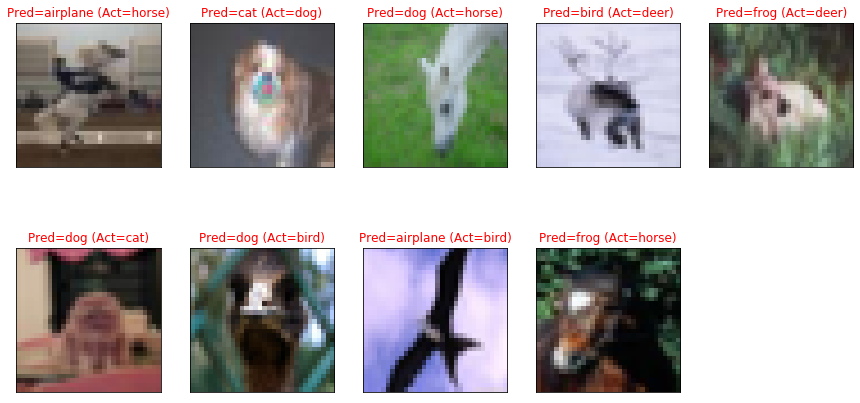

In [6]:
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

batch_size = 64
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
test_loader = dataloader.gettestdataloader()

# obtain one batch of test images
dataiterator = iter(test_loader)
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()
plotdata.PlotData.plotmisclassifiedimages(dataiterator=dataiterator,model=model,classes=classes,
                                          batch_size=batch_size,dogradcam=False,device=device)

In [7]:
utils.Utils.showaccuracyacrossclasses(class_correct=class_correct,class_total=class_total)

Test Accuracy of airplane: 88% (20552/23344)
Test Accuracy of automobile: 94% (22311/23722)
Test Accuracy of  bird: 79% (18719/23436)
Test Accuracy of   cat: 73% (17324/23437)
Test Accuracy of  deer: 84% (19887/23478)
Test Accuracy of   dog: 79% (18796/23741)
Test Accuracy of  frog: 90% (21307/23501)
Test Accuracy of horse: 88% (20957/23711)
Test Accuracy of  ship: 91% (21826/23748)
Test Accuracy of truck: 91% (21388/23382)

Test Accuracy (Overall): 86% (203067/235500)


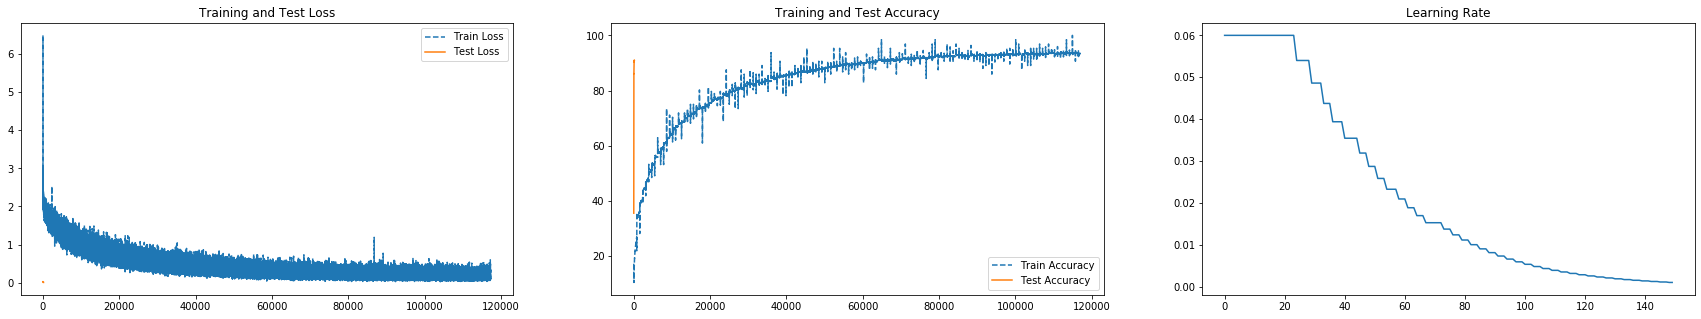

In [8]:
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True)

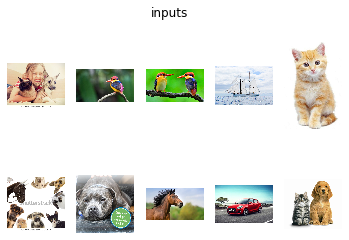

In [9]:
# from src.utils.modelutils import subplot
image_paths = glob.glob('./images/testimages/*.*')
images = list(map(lambda x: Image.open(x), image_paths))
subplot(images, title='inputs', nrows=2, ncols=5)

In [10]:
import torchvision

inputs = [torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])(
    x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

In [11]:
from src.visualization.gradcam.gradcam import gradcamof

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

gradcamof(model,inputs,classes)

ImportError: cannot import name 'gradcamof'